# Clustering Documents

In this notebook, you'll learn about **Latent Dirichlet Allocation** (LDA) algorithm, and how to use it to cluster documents based on automatically generated topics, made out of their content words.

Key-learning:
- Unsupervised machine learning for NLP
- Clustering Documents
- LDA
- python packages: *pandas*, [*gensim*](https://pypi.org/project/gensim/)

Terms in this notebook:
- Bag of Words (BoW)
- LDA
- Clustering
- TF/IDF

This notebook includes two recommended videos (total length: 25min).

Estimated reading duration: 1-2h.


# Setup

We start by importing [pandas](https://pandas.pydata.org/) - an essential tool for data scientists!

We load a .CSV (Comma Seperated Values) file of German news articles from https://github.com/tblock/10kGNAD


In [1]:
from IPython.display import YouTubeVideo

In [17]:
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

Pandas is a useful package to load CSV files and to parse them. It can also parse TSV - separated by tabs, or as in our case, separated by a `;`.  
Pandas is often used as the first-step for data scientists to load and analyze data.

In [18]:
df_articles = pd.read_csv('https://raw.githubusercontent.com/tblock/10kGNAD/master/articles.csv',
                 sep=';',       # this file is actually a TSV, separated by ";"
                 on_bad_lines='skip',
                 header=None,   # There is no header line for this CSV...
                 # .. so we define the column names here:
                 names=['article_category', 'content'],
                 # And by specifiying the column as a Categorical type,
                 # we can save computer memory! Yay!
                 dtype={'article_category': 'category'})

**Note:** Specifying a column with repeated strings as a category is a good Pandas' trick to be aware of. Often the dataset can't fit into the memory, and by specifiying columns as a categorical column when loading the data (`pd.read_csv`), we get to spare memory and allow the dataset to fit the working memory better.

In [4]:
df_articles

,article_category,content
0,Etat,"Die ARD-Tochter Degeto hat sich verpflichtet, ..."
1,Etat,App sei nicht so angenommen worden wie geplant...
2,Etat,Mitarbeiter überreichten Eigentümervertretern ...
3,Etat,Service: Jobwechsel in der Kommunikationsbranc...
4,Etat,Was Sie über diese Woche wissen sollten - und ...
...,...,...
9571,Wissenschaft,Die Fundstelle in Südengland ist Unesco-Weltku...
9572,Wissenschaft,Im Team arbeitet auch ein Inspektor der sudane...
9573,Wissenschaft,Die zentrale Frage des Projekts: Siedelten Ägy...
9574,Wissenschaft,Klimatische Verschlechterungen dürften zur Auf...


Our corpus contains 9 categories, as seen below.  
However, our plan now is to **ignore them**, and instead, use an **un**supervised algorithm to deduct the topics only by the articles content.   
Or in other words: we will *cluster* those documents based on their content.

In [5]:
df_articles['article_category'].cat.categories

Index(['Etat', 'Inland', 'International', 'Kultur', 'Panorama', 'Sport', 'Web',
       'Wirtschaft', 'Wissenschaft'],
      dtype='object')

# Clustering with Latent Dirichlet Allocation (LDA)

## Introduction

We start by clustering our data as an unsupervised learning task: **topic modeling**.

There are many different methods to cluster documents. One of these methods is *topic modeling* - where an algorithm assigns a *topic* to each document and clusters these documents by these topics.

Documents can be represented as a distribution of their words: their occurrences and frequencies. A set of words, which are relatively not frequent but are common to several documents, can express a document topic.  
For example, suppose we locate documents with the words 'Android', 'OnePlus' and 'iPhone' in them. Based on the frequency of these words, we could assume that these documents are related to mobile phones.

[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) is a distribution on probability distributions. In other words, it can handle the frequency of which a set of words appear (which have by themselves, each one, a frequency).

For a deeper mathematical explanation of this distribution, watch this recommended video: https://www.youtube.com/watch?v=nfBNOWv1pgE

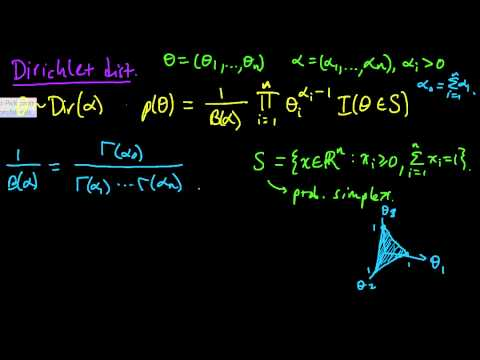

In [6]:
YouTubeVideo('nfBNOWv1pgE')

LDA is an unsupervised algorithm that assigns topics to every document. These topics are described as a set of words.  
Each document can contain several topics - more than just one topic.  
For example, some article about Apple can be 80% mobile phones and 20% about business innovations or income.

The [LDA paper](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) is a milestone in NLP and one of the recommended readings.

If you're interested to learn more about the algorithm method, watch this video: https://www.youtube.com/watch?v=DWJYZq_fQ2A.

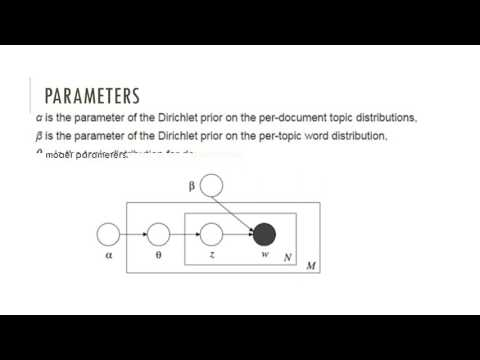

In [7]:
YouTubeVideo('DWJYZq_fQ2A')

Now, let's examine our German data set with LDA:

In previous exercises, you got to know NLTK.

### Stemming
Here we will also use NLTK's methods of **stemming** the words. By returning to the root of the word, its stem, we reduce the dimensionality: the number of words in the vocabulary decreases. For example, instead of having different words for the singular and plural form - 'word' <--> 'words' or 'Kanzler', 'Kanzlers', 'Kanzlei', etc., we trim those words into 'Kanzl'. Hence we can reduce the size of the vocabulary by at least half.

### Stop Words
We will also remove `stopwords` from our text. In English, words such as: `a`, `an`, and `the` will be removed, as they don't add much to the meaning of the sentence. For each language, there is a different curated list of such words, and NLTK is a great source for those.

### GenSim
In this exercise, you'll be introduced to another package, specialized in topic modeling, called `gensim`:
https://radimrehurek.com/gensim/



In [8]:
%pip install -U gensim --quiet

In [9]:
from pprint import pprint # for printing objects nicely

from gensim import corpora, models
from gensim.utils import simple_preprocess

## Instead of the gensim English stopwords...
# from gensim.parsing.preprocessing import STOPWORDS
## ...we use nltk's German stopwords:
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import numpy as np

from random import choice

np.random.seed(1234)

In [10]:
# Initialize the Stemmers
stemmer = SnowballStemmer('german')
german_stop_words = set(stopwords.words('german'))


def lemmatize_stemming(text):
  """lemmatize and stem a word"""
  return stemmer.stem(text)


def preprocess(text):
  """lemmatize and remove stopwords"""
  result = [lemmatize_stemming(token)
            for token in simple_preprocess(text)
            if token not in german_stop_words and len(token) > 3]
  return result

In our DataFrame, we have a table contains the articles and their topics.

We only need the articles for this tasks - we will create our own topics. So, let's start by converting the articles column into a ist of all the articles:

In [11]:
all_articles = df_articles['content'].to_list()
all_articles[:5]

['Die ARD-Tochter Degeto hat sich verpflichtet, ab August einer Quotenregelung zu folgen, die für die Gleichstellung von Regisseurinnen sorgen soll. In mindestens 20 Prozent der Filme, die die ARD-Tochter Degeto produziert oder mitfinanziert, sollen ab Mitte August Frauen Regie führen. Degeto-Chefin Christine Strobl folgt mit dieser Selbstverpflichtung der Forderung von Pro Quote Regie. Die Vereinigung von Regisseurinnen hatte im vergangenen Jahr eine Quotenregelung gefordert, um den weiblichen Filmschaffenden mehr Gehör und ökonomische Gleichstellung zu verschaffen. Pro Quote Regie kritisiert, dass, während rund 50 Prozent der Regie-Studierenden weiblich seien, der Anteil der Regisseurinnen bei Fernsehfilmen nur bei 13 bis 15 Prozent liege. In Österreich sieht die Situation ähnlich aus, auch hier wird von unterschiedlichen Seiten Handlungsbedarf angemahnt. Aber wie soll dieser aussehen? Ist die Einführung der Quotenregelung auch für die österreichische Film- und Fernsehlandschaft sinn

## Preprocessing

Let's see an example, what happens when we pre-process a document.

Look at the output of this cell, and compare the tokenized original document, to the lemmatized document:

In [12]:
print('original document: ')
article = choice(all_articles)
print(article, "\n")

# This time, we don't care about punctuations as tokens (Can you think why?): because we will delete them in the preprocess function we defined before (with if statemnet "len(token) > 3")
print('original document, broken into words: ')
words = [word for word in article.split(' ')]
print(words, "\n")
print("Vocabulary size of the original article:", len(set(words)))

# now let's see what happens when we pass the article into our preprocessing
# method:
print('\n\n tokenized and lemmatized document: ')
preprocessed_article = preprocess(article)
print(preprocessed_article, '\n')
print("Vocabulary size after preprocessing:", len(set(preprocessed_article)))

original document: 
Nationalistische Bewegung protestiert gegen die geplante Bildung einer Serben-Gemeinschaft. Prishtina – Tausende Regierungsgegner haben am Samstag im Kosovo gegen ein von der EU vermitteltes Abkommen zur Normalisierung der Beziehungen zu Serbien protestiert. Einige Demonstranten griffen die Polizei im Zentrum der Hauptstadt Prishtina (Pristina) mit Brandsätzen und Steinen an. Mehrere Fensterscheiben des Regierungssitzes gingen zu Bruch, zudem brach ein Feuer in dem Gebäude aus. Die Sicherheitskräfte feuerten Tränengas auf die Demonstranten ab. Zu den Ausschreitungen war es nach dem Abschluss einer von drei führenden Oppositionsparteien im Stadtzentrum abgehaltenen Protestveranstaltung gekommen. Die Opposition läuft Sturm gegen das Vorhaben, der serbischen Minderheit im Kosovo mehr Rechte zuzugestehen. Auch die Beilegung eines Grenzstreits mit dem benachbarten Montenegro lehnt die Opposition mit der Begründung ab, damit seien Gebietsverluste verbunden. Der Opposition

Now let's pre-process all the documents.  
This is a heavy procedure, and may take a bit ;)

In [13]:
processed_docs = list(map(preprocess, all_articles))
processed_docs[:10]

[['tocht',
  'degeto',
  'verpflichtet',
  'august',
  'quotenregel',
  'folg',
  'gleichstell',
  'regisseurinn',
  'sorg',
  'mindest',
  'prozent',
  'film',
  'tocht',
  'degeto',
  'produziert',
  'mitfinanziert',
  'soll',
  'mitt',
  'august',
  'frau',
  'regi',
  'fuhr',
  'degeto',
  'chefin',
  'christin',
  'strobl',
  'folgt',
  'forder',
  'quot',
  'regi',
  'verein',
  'regisseurinn',
  'vergang',
  'jahr',
  'quotenregel',
  'gefordert',
  'weiblich',
  'filmschaff',
  'mehr',
  'gehor',
  'okonom',
  'gleichstell',
  'verschaff',
  'quot',
  'regi',
  'kritisiert',
  'rund',
  'prozent',
  'regi',
  'studier',
  'weiblich',
  'seien',
  'anteil',
  'regisseurinn',
  'fernsehfilm',
  'prozent',
  'lieg',
  'osterreich',
  'sieht',
  'situation',
  'ahnlich',
  'seit',
  'handlungsbedarf',
  'angemahnt',
  'ausseh',
  'einfuhr',
  'quotenregel',
  'osterreich',
  'film',
  'sinnvoll',
  'diskuti',
  'forum'],
 ['angenomm',
  'word',
  'geplant',
  'weg',
  'gering',
  '

## Setting Up The Dictionary

Our preprocessing is complete.

We now need to calculate the occurance frequencies of each of our stemmed words. But first, we will create a vocabulary dictionary where every word appears once. Every article would be represented as a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model), an unordered set of words that the article contain.

---

Q: Why is it called bag-of-words?

Hint: Think about your probability lessons - where you had randomly picked out white or black balls out of a bag...

In [14]:
dictionary = corpora.Dictionary(processed_docs)

Let's take a look:

In [16]:
for idx, (k, v) in enumerate(dictionary.iteritems()):
    print(k, v)
    if idx >= 10:
        break

### BTW: `enumerate` is a great python function!
### It automatically creates an index, an auto-incremented counter variable,
### that represents the position of every object in the collection.

### Read more about it here: https://realpython.com/python-enumerate/

0 ahnlich
1 angemahnt
2 anteil
3 august
4 ausseh
5 chefin
6 christin
7 degeto
8 diskuti
9 einfuhr
10 fernsehfilm


Second, we filter the tokens that may appear to often.

We have full control on the process.

### Model Hyperparameter tuning

### Your Turn:
#### Exercise 1 - Hyperparameter effect on the model output:
**Q:** How would changing these parameters influence the result?  
After running this example, please return here to change them and try them out.

In [31]:
## Model hyper parameters:

## These are the dictionary preparation parameters:
filter_tokens_if_container_documents_are_less_than = 10 # filters out words that appear in fewer than n documents. If we set it too low we may not be able interpret topics anymore
filter_tokens_if_appeared_percentage_more_than = 0.4 # if we set it too low we will filter rare and "important" words that help to define a topic
keep_the_first_n_tokens=100000

## and the LDA Parameters:
num_of_topics = 9 # I changed 10 to 9 because we have 9 topics in our corpus
alpha = 0.01
eta = 0.01

# Quote: alpha and eta can be thought of as smoothing parameters when we compute how much each document "likes" a topic (in the case of alpha) or how much each topic "likes" a word (in the case of gamma).
#        A higher alpha makes the document preferences "smoother" over topics, and a higher eta makes the topic preferences "smoother" over words."""

#I found this description here: https://ethen8181.github.io/machine-learning/clustering/topic_model/LDA.html

# I set alpha and eta this way because I think that the topics in our corpus are hihgly related to each other and a documant may have many topics,
# therefore we need to focus on fewer words and allow a document to have fewer topics fpr thei better difinition (lower eta and alpha).

In [32]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens)

We now create a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW) dictionary for each document, using [gensim's dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) tool.

It will be in the format of:

```{ 'word_id': count }```


In [33]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Let's take a look at the result.

Our corpus contains now only word_ids, not the words themselves, so we have to peek into the dictionary to know which word that id represents:

In [34]:
# randomly choose an article from the corpus:
sample_bow_doc = choice(bow_corpus)

print('The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:')
print(sample_bow_doc, '\n\n')

print ('We peek in the dictionary: for each word_id, we get its assigned word:')
for word_id, word_freq in sample_bow_doc:
  real_word = dictionary[word_id]
  print(f'Word #{word_id} ("{real_word}") appears {word_freq} time.')

The processed bag-of-word document is just pairs of (word_id, # of occurnces) and looks like this:
[(65, 2), (69, 1), (101, 1), (147, 1), (157, 2), (190, 1), (234, 1), (255, 1), (270, 1), (282, 1), (308, 3), (368, 1), (384, 2), (397, 1), (408, 1), (444, 3), (452, 1), (478, 1), (489, 1), (552, 1), (562, 1), (632, 1), (792, 1), (799, 1), (809, 1), (819, 1), (821, 1), (836, 1), (863, 2), (866, 1), (988, 1), (1016, 1), (1025, 2), (1055, 7), (1113, 1), (1248, 1), (1289, 3), (1299, 1), (1326, 1), (1496, 1), (1549, 1), (1551, 1), (1647, 1), (1652, 1), (1870, 1), (1997, 1), (2080, 1), (2109, 1), (2129, 1), (2216, 1), (2368, 1), (2571, 1), (2708, 2), (2816, 1), (2829, 1), (2976, 1), (3188, 1), (3242, 1), (3259, 1), (3328, 1), (3916, 1), (3943, 1), (3985, 2), (4339, 1), (4453, 1), (4634, 2), (5652, 1), (6181, 1), (7623, 1), (8099, 2), (8657, 1), (8670, 8), (8759, 1), (9791, 1), (9847, 1), (11470, 1), (12784, 1)] 


We peek in the dictionary: for each word_id, we get its assigned word:
Word #65 (

## LDA model using Bag-of-words

Let's start by applying the LDA model using the bag-of-words (Warning: this could take a while):

In [35]:
lda_model = models.LdaMulticore(bow_corpus,
                                num_topics=num_of_topics,
                                id2word=dictionary,
                                passes=5,
                                workers=2,
                                iterations = 5, # I put iterations for more training of the model
                                eta = eta,
                                alpha = alpha
                                )

It is done!

Now we can observe which topics the model had extracted from the documents.

- *Topics* are made of sets of words and their distribution for that topic, representing their weight in that topic.
- Every document may be composed of multiple topics, with different weights representing the relation to each topics.

We will loop over the extracted topics and examine the words that construct them.

In [36]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')

Topic: 0 	 Words: 0.005*"wien" + 0.004*"osterreich" + 0.004*"gibt" + 0.004*"seit" + 0.003*"schon" + 0.003*"viel" + 0.003*"zwei" + 0.003*"jahrig" + 0.003*"imm" + 0.003*"beim"
Topic: 1 	 Words: 0.006*"neu" + 0.005*"wien" + 0.004*"osterreich" + 0.004*"seit" + 0.004*"prozent" + 0.004*"standard" + 0.004*"grund" + 0.004*"steht" + 0.004*"euro" + 0.004*"gross"
Topic: 2 	 Words: 0.011*"prozent" + 0.006*"neu" + 0.006*"euro" + 0.005*"osterreich" + 0.005*"wien" + 0.004*"seit" + 0.003*"beim" + 0.003*"weit" + 0.003*"land" + 0.003*"zwei"
Topic: 3 	 Words: 0.008*"euro" + 0.006*"prozent" + 0.006*"million" + 0.005*"wien" + 0.005*"osterreich" + 0.004*"neu" + 0.004*"gross" + 0.004*"schon" + 0.004*"etwa" + 0.004*"unternehm"
Topic: 4 	 Words: 0.008*"wien" + 0.005*"euro" + 0.004*"osterreich" + 0.004*"spiel" + 0.004*"neu" + 0.004*"seit" + 0.003*"gross" + 0.003*"schon" + 0.003*"standard" + 0.003*"viel"
Topic: 5 	 Words: 0.004*"seit" + 0.004*"schon" + 0.004*"neu" + 0.003*"wien" + 0.003*"zwei" + 0.003*"osterreic

## TF / IDF

Let's take it one step further. We will cluster our document by running the LDA using [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

We start with TF/IDF calculation on our bag-of-words.
TF/IDF accepts a dictionary of word frequencies as an input, and it calculates the term frequency and the inversed document frequency accordingly.

Its output is a re-weighted dictionary of the documents term frequencies:

In [37]:
# initialize a tfidf from our corpus
tfidf = models.TfidfModel(bow_corpus)

# apply it on our corpus
tfidf_corpus = tfidf[bow_corpus]

pprint(tfidf_corpus[0][:10])

[(0, 0.0667086950841424),
 (1, 0.08543973752985852),
 (2, 0.1557940056452628),
 (3, 0.10984349198894917),
 (4, 0.10599829818638576),
 (5, 0.13051677048653784),
 (6, 0.10454248999145317),
 (7, 0.09462873248444831),
 (8, 0.16817827657460563),
 (9, 0.05473773449333437)]


In [38]:
# the new tfidf corpus is just our corpus - but transformed. It has the same size of documents:
assert len(bow_corpus) == len(tfidf_corpus)

Now let's apply LDA on the tfidf corpus, with the same amount of topics.

You can play with the # of passes, if the model doesn't converge properly

In [39]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus,
                                      num_topics=num_of_topics,
                                      id2word=dictionary,
                                      passes=5,
                                      workers=4,
                                      iterations = 5, # I put iterations for more training of the model
                                      eta = eta,
                                      alpha = alpha)

In [40]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.008*"volltext" + 0.008*"basier" + 0.007*"artikel" + 0.007*"rechtlich" + 0.006*"verfug" + 0.005*"grund" + 0.005*"steht" + 0.004*"euro" + 0.003*"prozent" + 0.003*"russland"
Topic: 1 	 Word: 0.003*"novomatic" + 0.002*"prozent" + 0.002*"osterreich" + 0.002*"wien" + 0.002*"appl" + 0.002*"million" + 0.002*"euro" + 0.001*"spiel" + 0.001*"thiem" + 0.001*"neu"
Topic: 2 	 Word: 0.003*"prozent" + 0.002*"fluchtling" + 0.002*"wien" + 0.002*"osterreich" + 0.002*"mensch" + 0.002*"tier" + 0.002*"neu" + 0.002*"etwa" + 0.002*"forsch" + 0.001*"gibt"
Topic: 3 	 Word: 0.004*"forsch" + 0.004*"wissenschaft" + 0.003*"studi" + 0.002*"mensch" + 0.002*"untersuch" + 0.002*"universitat" + 0.002*"institut" + 0.002*"gen" + 0.001*"natur" + 0.001*"etwa"
Topic: 4 	 Word: 0.003*"satellit" + 0.002*"fahrzeug" + 0.002*"forsch" + 0.002*"erd" + 0.002*"teilch" + 0.002*"komet" + 0.002*"physik" + 0.002*"raket" + 0.002*"europa" + 0.002*"polizei"
Topic: 5 	 Word: 0.005*"prozent" + 0.004*"lufthansa" + 0.004*"vol

## Inference

Now that we have a topic-modeler, let's use it on one of the articles.

In [41]:
# randomly pick an article:
test_doc = choice(range(len(processed_docs)))
processed_docs[test_doc][:50]

['spiel',
 'andauernd',
 'siegesseri',
 'serb',
 'beendet',
 'schweiz',
 'steht',
 'london',
 'world',
 'tour',
 'final',
 'halbfinal',
 'london',
 'schweiz',
 'rog',
 'fed',
 'dienstag',
 'zweit',
 'gruppenspiel',
 'london',
 'world',
 'tour',
 'final',
 'siegesseri',
 'novak',
 'djokovic',
 'erfolg',
 'hintereinand',
 'beendet',
 'uberzeug',
 'numm',
 'ein',
 'tennis',
 'weltranglist',
 'steht',
 'eidgenoss',
 'vorzeit',
 'halbfinal',
 'djokovic',
 'verlor',
 'erstmal',
 'seit',
 'mehr',
 'drei',
 'jahr',
 'sieg',
 'parti',
 'hall',
 'basis',
 'erfolg']

Using the original BOW model:

In [42]:
for index, score in sorted(lda_model[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print(f"Topic match score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")

Topic match score: 0.3042103350162506 
Topic: 0.008*"wien" + 0.005*"euro" + 0.004*"osterreich" + 0.004*"spiel" + 0.004*"neu" + 0.004*"seit" + 0.003*"gross" + 0.003*"schon" + 0.003*"standard"
Topic match score: 0.20305734872817993 
Topic: 0.005*"wien" + 0.004*"osterreich" + 0.004*"gibt" + 0.004*"seit" + 0.003*"schon" + 0.003*"viel" + 0.003*"zwei" + 0.003*"jahrig" + 0.003*"imm"
Topic match score: 0.19147653877735138 
Topic: 0.011*"prozent" + 0.006*"neu" + 0.006*"euro" + 0.005*"osterreich" + 0.005*"wien" + 0.004*"seit" + 0.003*"beim" + 0.003*"weit" + 0.003*"land"
Topic match score: 0.09541898220777512 
Topic: 0.008*"fluchtling" + 0.006*"wien" + 0.006*"seit" + 0.004*"osterreich" + 0.004*"zwei" + 0.004*"neu" + 0.004*"land" + 0.004*"mensch" + 0.003*"jahrig"
Topic match score: 0.08137684315443039 
Topic: 0.006*"neu" + 0.005*"wien" + 0.005*"bereit" + 0.004*"seit" + 0.004*"gross" + 0.003*"zwei" + 0.003*"viel" + 0.003*"polit" + 0.003*"schon"
Topic match score: 0.04195510223507881 
Topic: 0.006*"

And with the TF/IDF model:

In [43]:
for index, score in sorted(lda_model_tfidf[bow_corpus[test_doc]], key=lambda tup: -1*tup[1]):
    print("Topic match score: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))

Topic match score: 0.4548451602458954	 
Topic: 0.003*"novomatic" + 0.002*"prozent" + 0.002*"osterreich" + 0.002*"wien" + 0.002*"appl" + 0.002*"million" + 0.002*"euro" + 0.001*"spiel" + 0.001*"thiem"
Topic match score: 0.3390456438064575	 
Topic: 0.006*"prozent" + 0.003*"osterreich" + 0.003*"euro" + 0.002*"wien" + 0.002*"salzburg" + 0.002*"spiel" + 0.002*"gewerkschaft" + 0.002*"arbeitsmarkt" + 0.002*"million"
Topic match score: 0.07685111463069916	 
Topic: 0.008*"volltext" + 0.008*"basier" + 0.007*"artikel" + 0.007*"rechtlich" + 0.006*"verfug" + 0.005*"grund" + 0.005*"steht" + 0.004*"euro" + 0.003*"prozent"
Topic match score: 0.06241225078701973	 
Topic: 0.003*"prozent" + 0.002*"fluchtling" + 0.002*"wien" + 0.002*"osterreich" + 0.002*"mensch" + 0.002*"tier" + 0.002*"neu" + 0.002*"etwa" + 0.002*"forsch"
Topic match score: 0.022339532151818275	 
Topic: 0.003*"satellit" + 0.002*"fahrzeug" + 0.002*"forsch" + 0.002*"erd" + 0.002*"teilch" + 0.002*"komet" + 0.002*"physik" + 0.002*"raket" + 0.0

Calculating the [perplexity score](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94) (lower is better):

In [44]:
print('Perplexity: ', lda_model.log_perplexity(bow_corpus))
print('Perplexity TFIDF: ', lda_model_tfidf.log_perplexity(bow_corpus))

Perplexity:  -8.888971904487988
Perplexity TFIDF:  -9.432603128338178


### Exercise - inference

Now please try it on a new document!

Go to a news website, such as [orf.at](https://orf.at/) and copy an article of your choice here:

In [45]:
unseen_document = """Sobotka sprach in einer um eineinhalb Stunden verspäteten Pressekonferenz am Abend von einer „schwierigen“, aber „sachlichen und pointierten“ Diskussion im Hauptausschuss. Er meinte, dass von Gesundheitsminister Rudolf Anschober (Grüne), die „Notwendigkeit, Verhältnismäßigkeit und Richtigkeit“ der Maßnahmen erläutert worden seien. Zudem betonte Sobotka die Wichtigkeit der im Covid-Maßnahmengesetz vorgesehenen Mitsprache des Parlaments bei Maßnahmen, bei denen auch die Freiheitsrechte betroffen seien.
Der Nationalratspräsident zitierte auch die deutsche Kanzlerin Angela Merkel, die die Maßnahmen im Kampf gegen die Pandemie als „demokratische Zumutung“ bezeichnet hatte. Dem sei nicht nur zuzustimmen, das sei auch zu unterstreichen, sagte er. Die Eindämmung der Pandemie könne aber nur gelingen, wenn sich alle Österreicher einbringen. Der Beschluss alleine reiche nicht, die Maßnahmen müssten auch im Geiste verinnerlicht werden, appellierte Sobotka an die Bevölkerung, die Maßnahmen mitzutragen.
Rendi-Wagner kritisiert Regierung
Die Opposition hatte schon vor der Sitzung – und dann auch noch einmal danach – ihre Kritik an der Regierung bekräftigt. „Die Bundesregierung hat die Kontrolle über das Infektionsgeschehen verloren und hat die schwierige Situation, vor der wir jetzt stehen, zu verantworten“, kritisierte SPÖ-Klub- und Parteivorsitzende Rendi-Wagner.
Sessel auf Tischen in einem geschlossenen Lokal
DEBATTEWie gerechtfertigt sind die Maßnahmen?"""

bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("Simply printing the lda_model output would look like this:")
pprint(lda_model[bow_vector])

print("\n\nSo let's make it nicer, by printing the topic contents:")
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Simply printing the lda_model output would look like this:
[(0, 0.034954432),
 (1, 0.04578427),
 (2, 0.058370806),
 (3, 0.034535795),
 (4, 0.06387109),
 (5, 0.12559825),
 (6, 0.27869034),
 (7, 0.2359726),
 (8, 0.12222243)]


So let's make it nicer, by printing the topic contents:
Score: 0.3432612717151642	 Topic: 0.008*"fluchtling" + 0.006*"wien" + 0.006*"seit" + 0.004*"osterreich" + 0.004*"zwei"
Score: 0.15783271193504333	 Topic: 0.006*"word" + 0.005*"mensch" + 0.004*"bereit" + 0.004*"seien" + 0.004*"land"
Score: 0.13743340969085693	 Topic: 0.006*"neu" + 0.005*"wien" + 0.005*"bereit" + 0.004*"seit" + 0.004*"gross"
Score: 0.11441276967525482	 Topic: 0.004*"seit" + 0.004*"schon" + 0.004*"neu" + 0.003*"wien" + 0.003*"zwei"
Score: 0.06637903302907944	 Topic: 0.008*"wien" + 0.005*"euro" + 0.004*"osterreich" + 0.004*"spiel" + 0.004*"neu"
Score: 0.0641365647315979	 Topic: 0.005*"wien" + 0.004*"osterreich" + 0.004*"gibt" + 0.004*"seit" + 0.003*"schon"
Score: 0.05682330206036568	 Topic: 0.011*

## Visualization

Finally, there are packages that can visulaize the results, such as [pyLDAvis](https://pypi.org/project/pyLDAvis/) and [tmplot](https://pypi.org/project/tmplot/).

Let's take a look at pyLDAvis visualization result.

**Please note:** this is an old and unmaintained package. It is easier to run it in Google-Colab than on your laptop. But, if you still try running it locally, please try **lowering your python version** (3.6 / 3.6 / 3.8) when you create the poetry environment for this exercise.

In [46]:
%pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.0 MB/s eta 0:00:00


In [47]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

bow_lda_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

pyLDAvis.display(bow_lda_data)

# Your turn - Do it yourself:

Replace the given corpus with one in another language - maybe your own native language? You can find corpus online, for example:
- https://www.corpusdata.org/intro.asp
- or here: https://www.clarin.eu/resource-families/newspaper-corpora
- or even in nltk: https://www.nltk.org/nltk_data/
- In this github, there are many datasets that can be loaded through their `raw` url: https://github.com/selva86/datasets

Careful: You will need to change the [Stemming](https://snowballstem.org/algorithms/) and the [Stopwords](https://www.kaggle.com/rtatman/stopword-lists-for-19-languages) to support your language. Make a web-search after the appropriate ones (if they exist..)

Use the notebook to reproduce the result.  
Try changing the parameters to get a *satisfying level of clustering*.  
Which parameters worked best for the language you chose?

##### Help note

If your corpus is a csv, [pandas' read_csv method](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) would be the best way to tackle it.

If it is, however a text file or a zip of text files, you will need another way to load them. Luckily, python is working well with both - text and zip files, with a built-in support.

###### Example with text
For the sake of this example, let's download two files: one text file, and one gzip file, from this website:

https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-6260-A

In [48]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A{/README.txt,/hindmonocorp05.plaintext.gz}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4472  100  4472    0     0   4454      0  0:00:01  0:00:01 --:--:--  4458
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2353M  100 2353M    0     0  24.7M      0  0:01:35  0:01:35 --:--:-- 25.2M


Files are accessed using the `Path` package of python's pathlib:

In [49]:
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To access a file, we use its path in Path, like so:

`Path('Folder/filename.extension')`

Path has many methods for files and folder. Including looping over files in folder, checking if a file exists, etc.

Read more about it here: https://docs.python.org/3/library/pathlib.html

In [50]:
readme_file = Path('README.txt')

if readme_file.exists():
  # read the text content into a variable
  file_content = readme_file.read_text()
  print(file_content)
else:
  print("README.txt was not found...")

HindEnCorp 0.5 and HindMonoCorp 0.5 File Formats

This file describes the file formats of the Hindi-English and Hindi-only
corpora released in 2014 under the names HindEnCorp 0.5 and HindMonoCorp 0.5.

More details about the preparation of the corpora can be found in the paper:

  Ondřej Bojar, Vojtěch Diatka, Pavel Rychlý, Pavel Straňák, Aleš Tamchyna
  and Dan Zeman. HindEnCorp - Hindi-English and Hindi-only Corpus for
  Machine Translation. In Proc. of LREC 2014. Reykjavik, Iceland. ISBN
  978-2-9517408-8-4. ELRA. 2014.

or on the corpora web page:
  http://ufal.mff.cuni.cz/hindencorp

Please cite this paper if you make any use of the corpora. BibTeX citation
format below.


Common Properties
-----------------

All the files are plain text:

- compressed with gzip
- encoded in UTF-8
- with unix line breaks (LF)
- with tab-delimited columns

The monolingual and parallel corpora have different columns.

The actual corpus text is stored in one (monolingual corpus) or two (parallel
corp

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If the file is a `.zip` file, you can open it and read its data without actually extracting all the files from it.

https://docs.python.org/3/library/gzip.html

Also, [requests](https://requests.readthedocs.io/en/latest/) is a great package of retrieving content from a URL.

###### Example with zipped files

In [51]:
import gzip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
# this would download the file (but it's 2 GB, so go easy on your internet provider...):
# file = requests.get('https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-6260-A/hindmonocorp05.plaintext.gz')
# with gzip.open(file.content, 'rb') as gz:
#  ...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this example, we will open the zip and read the text lines.
The text is in hindi, so we have to decode it into `UTF-8` format:

In [53]:
with gzip.open('hindmonocorp05.plaintext.gz', 'rb') as gz:
  for i in range(10):
    line = gz.readline()
    words = line.decode('utf8').split()
    print(words)

['hwt2013', '<s>', 'लेकिन', 'गांव', 'के', 'जगदीश', 'मेघवाल,', 'मोहन...']
['spiderling', '<s>', 'विटामिन', 'सी', 'शरीर', 'में', 'रोग', 'पैदा', 'करने', 'वाले', 'विषाणुओं', 'से', 'लड़ने', 'की', 'ताकत', 'पैदा', 'करता', 'है', 'और', 'शरीर', 'में', 'इसकी', 'संतुलित', 'मात्रा', 'बने', 'रहने', 'से', 'रोग', 'प्रतिरोधक', 'क्षमता', 'मजबूत', 'रहती', 'है।']
['spiderling', '<s>', 'इन', 'बोतलों', 'के', 'बहुत', 'कम', 'पैसे', 'मिलते', 'हैं।']
['commoncrawl', '<a>', 'कार्टून', ':-', 'रे', 'लोकपाल', 'आ', 'गया', 'तू', '?', 'शाबाश....', '19', '0']
['spiderling', '<s>', 'प्रखर', 'बुद्धि', 'तेजस्वी', 'बालक', 'राजेन्द्र', 'बाल्यावस्था', 'में', 'ही', 'फारसी', 'में', 'शिक्षा', 'ग्रहण', 'करने', 'लगा', 'और', 'उसके', 'पश्चात', 'प्राथमिक', 'शिक्षा', 'के', 'लिए', 'छपरा', 'के', 'जिला', 'स्कूल', 'में', 'नामांकित', 'हो', 'गया।']
['commoncrawl', '<a>', 'निदेशक', 'स्तर', 'का', 'एक', 'वैज्ञानिक', 'संस्थान', 'या', 'सहोदर', 'संस्थान', 'से', '(']
['commoncrawl', '<a>', 'गज़ब', 'का', 'बतंगड़', 'है!', ':)', 'हिट', 'तो', 'वैसे',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**IMPORTANT NOTE**: If your corpus, like that file example is very large (2.3GB zipped), then please don't load all the text: it will not fit in the memory and will only cause you trouble.  
Instead, you can use only the first 10 to 20k sentences, or so. For this exercise we just want you to get a hold of the steps and the proces involved in using LDA.

# Afterword

Gensim is not the only library that implements the LDA algorithm.
Another package that does LDA is [tomotopy](https://bab2min.github.io/tomotopy/v0.12.3/en/) - sometimes even faster than gensim. Additionaly, it is implemented as part of [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) - which we use often in the course.

Here's a jupyter example using Scikit-learn and spaCy: https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

Since we won't dive deeper into the LDA topic in this course, if you wish to know more about the statistics behind it, [this video](https://www.youtube.com/watch?v=0jQo8lVRHRY) of a lesson by the researcher [Nando de Freitas](https://linkedin.com/in/nandodefreitas) gives a good overview.

In [59]:
import pandas as pd

#I was not able to find a dataset with Belarusian languge, so that I chose a Ruissian dataset of news articles of one new portal

df = pd.read_csv("hf://datasets/TopicNet/Lenta/data/Lenta.csv.gz",
                 on_bad_lines='skip',
                 header=0,
                 nrows = 10000, # I used a similar number as in the example dataset
                 dtype={'topic': 'category'})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,url,title,text,topic,tags,lemmatized,year,month,day,time_n,lemmatized_title,topmine,vw_text,id
0,449272,https://lenta.ru/news/2013/01/01/fire2/,В ЮАР четыре тысячи человек остались без крова...,"В ЮАР произошел пожар, в результате которого п...",Мир,Все,юар произойти пожар результат погибнуть ожог т...,2013,1,1,449272,в юар четыре тысяча человек остаться без кров ...,место_настоящее состояние_алкогольный_опьянени...,0 |@word юар произойти пожар результат погибну...,0
1,449273,https://lenta.ru/news/2013/01/01/why/,Названа возможная причина давки в Абиджане,Давка в крупнейшем городе Кот-д'Ивуара Абиджан...,Мир,Все,давка крупный город кот ивуар абиджан начаться...,2013,1,1,449273,назвать возможный причина давка в абиджан,собраться_тысяча главный_вход давка_официальны...,1 |@word давка крупный город кот ивуар абиджан...,1
2,449274,https://lenta.ru/news/2013/01/01/egypt/,Политические партии Египта приняли поправки в ...,Политические партии и общественные организации...,Мир,Все,политический партия общественный организация е...,2013,1,1,449274,политический партия египет принять поправка в ...,секретарить_президент изменение_закон партия_б...,2 |@word политический партия общественный орга...,2
3,449275,https://lenta.ru/news/2013/01/01/georgia/,Иванишвили объявил о прекращении преследования...,Премьер-министр Грузии Бидзина Иванишвили в но...,Бывший СССР,Все,премьер министр грузия бидзин иванишвили новог...,2013,1,1,449275,иванишвили объявить о прекращение преследовани...,выборы_коалиция_грузинский_мечта президент_саа...,3 |@word премьер министр грузия бидзин иванишв...,3
4,449276,https://lenta.ru/news/2013/01/01/freed/,Задержанных на Триумфальной отпустили,"Полиция отпустила всех участников акции ""Страт...",Россия,Все,полиция отпустить участник акция стратегия три...,2013,1,1,449276,задержать на триумфальный отпустить,свобода_собрание собрание_митинг_демонстрация_...,4 |@word полиция отпустить участник акция стра...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,459267,https://lenta.ru/news/2013/04/17/ipoteka/,При покупке недвижимости россияне положились н...,Почти две трети россиян собираются приобрести ...,Дом,Все,треть россиянин собираться приобрести недвижим...,2013,4,17,459267,при покупка недвижимость россиянин положиться ...,компания_провести финансовый_средство приобрес...,9995 |@word треть россиянин собираться приобре...,9995
9996,459268,https://lenta.ru/news/2013/04/17/fen/,Архсовет Москвы сравнил торговый центр Ротенбе...,Архитектурный совет Москвы раскритиковал проек...,Дом,Все,архитектурный совет москва раскритиковать прое...,2013,4,17,459268,архсовет москва сравнить торговый центр ротенб...,комплекс_войти планировать_увеличить градостро...,9996 |@word архитектурный совет москва раскрит...,9996
9997,459269,https://lenta.ru/news/2013/04/17/tpy/,Московские пересадочные узлы застроят коммерче...,"""Московская кольцевая железная дорога"" планиру...",Дом,Все,московский кольцевой железный дорога планирова...,2013,4,17,459269,московский пересадочный узел застроить коммерч...,rgi_international поиск_инвестор офисный_недви...,9997 |@word московский кольцевой железный доро...,9997
9998,459270,https://lenta.ru/news/2013/04/17/spy/,В США выставили на продажу дом российских разв...,Служба федеральных маршалов США выставила на п...,Дом,Все,служба федеральный маршал сша выставить продаж...,2013,4,17,459270,в сша выставить на продажа дом российский разв...,гражданин_рф анна_чапман массачусетс_нью нью_й...,9998 |@word служба федеральный маршал сша выст...,9998


In [61]:
df['topic'].cat.categories

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['Бывший СССР', 'Дом', 'Из жизни', 'Интернет и СМИ', 'Культура', 'Мир',
       'Наука и техника', 'Россия', 'Спорт', 'Экономика'],
      dtype='object')

In [73]:
stemmer_ru = SnowballStemmer('russian')
russian_stop_words = set(stopwords.words('russian')) # russian is supported by nltk stemmer


def lemmatize_stemming(text):
  """lemmatize and stem a word"""
  return stemmer_ru.stem(text)


def preprocess(text):
  """lemmatize and remove stopwords"""
  result = [lemmatize_stemming(token)
            for token in simple_preprocess(text)
            if token not in russian_stop_words and len(token) > 3]
  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
stemmer_ru.stem("новогодний")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'новогодн'

In [71]:
all_articles_ru = df['text'].to_list()
all_articles_ru[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['В ЮАР произошел пожар, в результате которого погибли три человека, один получил ожоги, а четыре тысячи человек остались бездомными. Об этом 1 января сообщает Agence France-Presse. Пожар произошел в бедном районе Кейптауна. По информации Associated Press, этот район скученно застроен хижинами, зачастую возведенными самовольно. Для освещения, отопления и приготовления пищи там часто используются свечи, газовые горелки, керосиновые лампы и иные пожароопасные устройства. По предварительным данным, причиной возгорания стало неосторожное обращение с огнем в состоянии алкогольного опьянения. Распространению пламени способствовал сильный ветер. В настоящее время на месте работают команды спасателей. Они раздают пострадавшим продуктовые наборы, одежду и строительные материалы.',
 'Давка в крупнейшем городе Кот-д\'Ивуара Абиджане началась после того, как столкнулись два потока людей, двигавшихся в противоположные стороны. Об этом сообщает Agence France-Presse со ссылкой на представителя местно

In [74]:
print('original document: ')
article_ru = choice(all_articles_ru)
print(article_ru, "\n")

print('original document, broken into words: ')
words = [word for word in article_ru.split(' ')]
print(words, "\n")
print("Vocabulary size of the original article:", len(set(words)))

print('\n\n tokenized and lemmatized document: ')
preprocessed_article_ru = preprocess(article_ru)
print(preprocessed_article_ru, '\n')
print("Vocabulary size after preprocessing:", len(set(preprocessed_article_ru)))

original document: 
Московский школьник попал в больницу после того, как его, предположительно, избил дворник, сообщает 7 января "Интерфакс" со ссылкой на ГУ МВД России по Москве. Вечером в воскресенье, 6 января, в больницу поступил школьник 2001 года рождения, у которого диагностировали закрытый перелом челюсти и сотрясение головного мозга. Мальчик рассказал, что около школы на Изюмской улице (юго-запад Москвы) его избил дворник азиатской внешности. Подробности конфликта в сообщении ГУ МВД не приводятся. Сотрудники медучреждения сообщили о произошедшем в полицию. Полицейские проверяют информацию об избиении школьника. О задержаниях в рамках этого дела не сообщается. 

original document, broken into words: 
['Московский', 'школьник', 'попал', 'в', 'больницу', 'после', 'того,', 'как', 'его,', 'предположительно,', 'избил', 'дворник,', 'сообщает', '7', 'января', '"Интерфакс"', 'со', 'ссылкой', 'на', 'ГУ', 'МВД', 'России', 'по', 'Москве.', 'Вечером', 'в', 'воскресенье,', '6', 'января,', 'в

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
processed_docs_ru = list(map(preprocess, all_articles_ru))
processed_docs_ru[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['произошел',
  'пожар',
  'результат',
  'котор',
  'погибл',
  'человек',
  'получ',
  'ожог',
  'четыр',
  'тысяч',
  'человек',
  'оста',
  'бездомн',
  'январ',
  'сообща',
  'agence',
  'france',
  'presse',
  'пожар',
  'произошел',
  'бедн',
  'район',
  'кейптаун',
  'информац',
  'associated',
  'press',
  'район',
  'скучен',
  'застро',
  'хижин',
  'зачаст',
  'возведен',
  'самовольн',
  'освещен',
  'отоплен',
  'приготовлен',
  'пищ',
  'част',
  'использ',
  'свеч',
  'газов',
  'горелк',
  'керосинов',
  'ламп',
  'ин',
  'пожароопасн',
  'устройств',
  'предварительн',
  'дан',
  'причин',
  'возгоран',
  'стал',
  'неосторожн',
  'обращен',
  'огн',
  'состоян',
  'алкогольн',
  'опьянен',
  'распространен',
  'пламен',
  'способствова',
  'сильн',
  'ветер',
  'настоя',
  'врем',
  'мест',
  'работа',
  'команд',
  'спасател',
  'разда',
  'пострада',
  'продуктов',
  'набор',
  'одежд',
  'строительн',
  'материал'],
 ['давк',
  'крупн',
  'город',
  'ивуар',
  '

In [76]:
dictionary_ru = corpora.Dictionary(processed_docs_ru)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
for idx, (k, v) in enumerate(dictionary_ru.iteritems()):
    print(k, v)
    if idx >= 10:
        break

0 agence
1 associated
2 france
3 press
4 presse
5 алкогольн
6 бедн
7 бездомн
8 ветер
9 возведен
10 возгоран


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
filter_tokens_if_container_documents_are_less_than = 10 # filters out words that appear in fewer than n documents. If we set it too low we may not be able interpret topics anymore
filter_tokens_if_appeared_percentage_more_than = 0.4 # if we set it too low we will filter rare and "important" words that help to define a topic
keep_the_first_n_tokens=100000

num_of_topics = 10 # I have 10 topics in my corpus
alpha = 0.001
eta = 0.001

# Here, I set alpha and eta the same way because I think that the topics in my russian corpus are even more corelated and we need more restrictions for a better definiton of them.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
dictionary.filter_extremes(
    no_below=filter_tokens_if_container_documents_are_less_than,
    no_above=filter_tokens_if_appeared_percentage_more_than,
    keep_n=keep_the_first_n_tokens)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
bow_corpus_ru = [dictionary_ru.doc2bow(doc) for doc in processed_docs_ru]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
sample_bow_doc_ru = choice(bow_corpus_ru)

for word_id, word_freq in sample_bow_doc_ru:
  real_word = dictionary_ru[word_id]
  print(f'Word #{word_id} ("{real_word}") appears {word_freq} time.')

Word #22 ("команд") appears 1 time.
Word #23 ("котор") appears 1 time.
Word #26 ("мест") appears 1 time.
Word #43 ("получ") appears 1 time.
Word #59 ("сообща") appears 1 time.
Word #63 ("стал") appears 2 time.
Word #107 ("отмет") appears 3 time.
Word #108 ("официальн") appears 1 time.
Word #137 ("точн") appears 1 time.
Word #220 ("прошл") appears 2 time.
Word #247 ("возглавля") appears 1 time.
Word #260 ("заверш") appears 1 time.
Word #279 ("ноч") appears 1 time.
Word #291 ("побед") appears 1 time.
Word #356 ("московск") appears 1 time.
Word #398 ("наход") appears 1 time.
Word #520 ("перв") appears 1 time.
Word #527 ("российск") appears 1 time.
Word #528 ("сайт") appears 1 time.
Word #537 ("сыгра") appears 1 time.
Word #540 ("травм") appears 1 time.
Word #548 ("времен") appears 1 time.
Word #549 ("втор") appears 1 time.
Word #788 ("напада") appears 2 time.
Word #947 ("март") appears 2 time.
Word #1027 ("восточн") appears 1 time.
Word #1028 ("встреч") appears 2 time.
Word #1300 ("крис")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
lda_model = models.LdaMulticore(bow_corpus_ru,
                                num_topics=num_of_topics,
                                id2word=dictionary_ru,
                                passes=5,
                                iterations = 5,
                                alpha = alpha,
                                eta = eta,
                                workers=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
for idx, topic in lda_model.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Words: {topic}')

Topic: 0 	 Words: 0.017*"год" + 0.011*"котор" + 0.008*"компан" + 0.006*"процент" + 0.005*"сво" + 0.005*"сообща" + 0.005*"такж" + 0.005*"миллион" + 0.004*"рубл" + 0.004*"стран"
Topic: 1 	 Words: 0.015*"год" + 0.012*"котор" + 0.007*"сообща" + 0.006*"такж" + 0.004*"росс" + 0.004*"сво" + 0.004*"заяв" + 0.004*"человек" + 0.004*"врем" + 0.004*"январ"
Topic: 2 	 Words: 0.013*"год" + 0.012*"котор" + 0.008*"компан" + 0.007*"сообща" + 0.006*"тысяч" + 0.005*"такж" + 0.004*"дан" + 0.004*"росс" + 0.004*"ран" + 0.004*"март"
Topic: 3 	 Words: 0.019*"год" + 0.014*"котор" + 0.010*"фильм" + 0.007*"сообща" + 0.005*"такж" + 0.005*"стал" + 0.004*"рол" + 0.004*"нов" + 0.004*"главн" + 0.004*"картин"
Topic: 4 	 Words: 0.011*"котор" + 0.008*"год" + 0.008*"сообща" + 0.007*"такж" + 0.005*"заяв" + 0.005*"сво" + 0.004*"стран" + 0.004*"росс" + 0.004*"нов" + 0.004*"результат"
Topic: 5 	 Words: 0.013*"год" + 0.007*"котор" + 0.006*"сообща" + 0.005*"президент" + 0.005*"такж" + 0.004*"росс" + 0.004*"человек" + 0.004*"да

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TF/IDF

In [111]:
tfidf_ru = models.TfidfModel(bow_corpus_ru)

tfidf_corpus_ru = tfidf[bow_corpus_ru]

pprint(tfidf_corpus_ru[0][:10])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.08270464013667828),
 (1, 0.10592716192193878),
 (2, 0.09657576989094786),
 (3, 0.13618264402928898),
 (4, 0.1314154188677764),
 (5, 0.16181312677867854),
 (6, 0.12961052532701597),
 (7, 0.11731956766422645),
 (8, 0.10425270517857801),
 (9, 0.06786318676235667)]


In [112]:
assert len(bow_corpus_ru) == len(tfidf_corpus_ru)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [113]:
lda_model_tfidf = models.LdaMulticore(tfidf_corpus_ru,
                                      num_topics=num_of_topics,
                                      id2word=dictionary_ru,
                                      passes=5,
                                      iterations = 5,
                                      alpha = alpha,
                                      eta = eta,
                                      workers=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [114]:
for idx, topic in lda_model_tfidf.print_topics(num_of_topics):
    print(f'Topic: {idx} \t Word: {topic}')

Topic: 0 	 Word: 0.013*"год" + 0.012*"процент" + 0.010*"росс" + 0.007*"сообща" + 0.007*"котор" + 0.006*"апрел" + 0.006*"такж" + 0.006*"кипр" + 0.006*"миллион" + 0.005*"банк"
Topic: 1 	 Word: 0.014*"год" + 0.014*"игр" + 0.012*"котор" + 0.009*"процент" + 0.007*"однак" + 0.007*"компан" + 0.007*"такж" + 0.006*"доллар" + 0.006*"проект" + 0.006*"банк"
Topic: 2 	 Word: 0.013*"год" + 0.012*"котор" + 0.011*"боксер" + 0.008*"провел" + 0.007*"титул" + 0.007*"поединк" + 0.007*"миллион" + 0.007*"чемпион" + 0.006*"сообща" + 0.006*"нокаут"
Topic: 3 	 Word: 0.013*"котор" + 0.008*"год" + 0.006*"сообща" + 0.005*"такж" + 0.004*"человек" + 0.004*"сво" + 0.004*"учен" + 0.004*"однак" + 0.003*"март" + 0.003*"нескольк"
Topic: 4 	 Word: 0.023*"фильм" + 0.016*"год" + 0.012*"котор" + 0.012*"рол" + 0.009*"прем" + 0.009*"картин" + 0.009*"режиссер" + 0.007*"такж" + 0.007*"сообща" + 0.006*"актер"
Topic: 5 	 Word: 0.017*"год" + 0.013*"котор" + 0.006*"сообща" + 0.006*"такж" + 0.005*"росс" + 0.005*"президент" + 0.005*"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Testing

In [135]:
# randomly pick an article:
test_doc_ru = choice(range(len(processed_docs_ru))) # gets a number in the range of the corpus length
processed_docs_ru[test_doc_ru][:50]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['бывш',
 'руководител',
 'энергостр',
 'предъяв',
 'обвинен',
 'хищен',
 'миллиард',
 'рубл',
 'январ',
 'сообща',
 'новост',
 'ссылк',
 'анонимн',
 'источник',
 'слов',
 'собеседник',
 'агентств',
 'обвинен',
 'юр',
 'желябовск',
 'татьян',
 'муромцев',
 'татьян',
 'бондарев',
 'предъявл',
 'заочн',
 'местонахожден',
 'обвиня',
 'следств',
 'неизвестн',
 'исключ',
 'наход',
 'границ',
 'герман',
 'испан',
 'швейцар',
 'владеют',
 'имуществ',
 'желябовск',
 'муромцев',
 'бондарев',
 'объяв',
 'розыск',
 'реша',
 'вопрос',
 'заочн',
 'избран',
 'мер',
 'пресечен',
 'вид']

In [116]:
for index, score in sorted(lda_model[bow_corpus_ru[test_doc_ru]], key=lambda tup: -1*tup[1]):
    print(f"Topic match score: {score} \nTopic: {lda_model.print_topic(index, num_of_topics)}")

Topic match score: 0.2468344122171402 
Topic: 0.013*"год" + 0.007*"котор" + 0.006*"сообща" + 0.005*"президент" + 0.005*"такж" + 0.004*"росс" + 0.004*"человек" + 0.004*"дан" + 0.004*"стран" + 0.004*"полиц"
Topic match score: 0.2413790225982666 
Topic: 0.015*"год" + 0.012*"котор" + 0.007*"сообща" + 0.006*"такж" + 0.004*"росс" + 0.004*"сво" + 0.004*"заяв" + 0.004*"человек" + 0.004*"врем" + 0.004*"январ"
Topic match score: 0.159181147813797 
Topic: 0.011*"котор" + 0.008*"год" + 0.008*"сообща" + 0.007*"такж" + 0.005*"заяв" + 0.005*"сво" + 0.004*"стран" + 0.004*"росс" + 0.004*"нов" + 0.004*"результат"
Topic match score: 0.14083220064640045 
Topic: 0.019*"год" + 0.014*"котор" + 0.010*"фильм" + 0.007*"сообща" + 0.005*"такж" + 0.005*"стал" + 0.004*"рол" + 0.004*"нов" + 0.004*"главн" + 0.004*"картин"
Topic match score: 0.06095370277762413 
Topic: 0.019*"год" + 0.012*"процент" + 0.009*"котор" + 0.008*"доллар" + 0.007*"тысяч" + 0.006*"росс" + 0.006*"миллиард" + 0.005*"миллион" + 0.005*"рубл" + 0.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [117]:
for index, score in sorted(lda_model_tfidf[bow_corpus_ru[test_doc_ru]], key=lambda tup: -1*tup[1]):
    print("Topic match score: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, num_of_topics)))

Topic match score: 0.3453719913959503	 
Topic: 0.013*"котор" + 0.008*"год" + 0.006*"сообща" + 0.005*"такж" + 0.004*"человек" + 0.004*"сво" + 0.004*"учен" + 0.004*"однак" + 0.003*"март" + 0.003*"нескольк"
Topic match score: 0.2851561903953552	 
Topic: 0.014*"год" + 0.013*"котор" + 0.009*"сообща" + 0.008*"апрел" + 0.006*"такж" + 0.006*"дел" + 0.006*"однак" + 0.006*"человек" + 0.005*"сво" + 0.005*"полиц"
Topic match score: 0.21273741126060486	 
Topic: 0.017*"год" + 0.013*"котор" + 0.006*"сообща" + 0.006*"такж" + 0.005*"росс" + 0.005*"президент" + 0.005*"апрел" + 0.005*"сво" + 0.005*"театр" + 0.004*"групп"
Topic match score: 0.06154484301805496	 
Topic: 0.015*"год" + 0.010*"котор" + 0.008*"сообща" + 0.007*"российск" + 0.007*"росс" + 0.006*"компан" + 0.006*"апрел" + 0.005*"акц" + 0.005*"процент" + 0.005*"такж"
Topic match score: 0.031878918409347534	 
Topic: 0.014*"год" + 0.014*"игр" + 0.012*"котор" + 0.009*"процент" + 0.007*"однак" + 0.007*"компан" + 0.007*"такж" + 0.006*"доллар" + 0.006*"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Evaluating

In [121]:
print('Perplexity: ', lda_model.log_perplexity(bow_corpus_ru))
print('Perplexity TFIDF: ', lda_model_tfidf.log_perplexity(bow_corpus_ru))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -14.777953142959714
Perplexity TFIDF:  -125.76068600818448


In [123]:
unseen_document_ru = """Совбез ООН по запросу РФ 20 декабря проведет заседание по поставкам оружия Киеву.
Совбез ООН в пятницу, 20 декабря, проведет заседание по поставкам западного оружия Киеву.
Об этом сообщил первый зампостпреда миссии России при всемирной организации Дмитрий Полянский, передает РИА Новости.
Отмечается, что в понедельник, 16 декабря, в 23:00 по московскому времени Совбез обсудит ситуацию на Украине.
Заседание запросили западные страны. Ранее стало известно, что Минобороны Украины выделит дополнительные 1,1 миллиарда гривен (более 26 миллионов долларов) на покупку дронов.
Премьер-министр страны Денис Шмыгаль уточнил, что за 10 месяцев 2024 года правительство потратило 229 миллиардов гривен на закупку вооружения, боеприпасов и других средств для украинской армии.?"""

#source: https://lenta.ru/news/2024/12/16/sovbez-oon-provedet-zasedanie-po-postavkam-oruzhiya-ukraine/

bow_vector_ru = dictionary_ru.doc2bow(preprocess(unseen_document_ru))

pprint(lda_model[bow_vector])

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

[(0, 0.15752247),
 (1, 0.21014923),
 (2, 0.20212536),
 (3, 0.057394434),
 (4, 0.015524076),
 (5, 0.17231649),
 (6, 0.04982699),
 (8, 0.07982377),
 (9, 0.045447793)]
Score: 0.21954990923404694	 Topic: 0.015*"год" + 0.012*"котор" + 0.007*"сообща" + 0.006*"такж" + 0.004*"росс"
Score: 0.2015007585287094	 Topic: 0.017*"год" + 0.011*"котор" + 0.008*"компан" + 0.006*"процент" + 0.005*"сво"
Score: 0.1624584197998047	 Topic: 0.013*"год" + 0.012*"котор" + 0.008*"компан" + 0.007*"сообща" + 0.006*"тысяч"
Score: 0.12340042740106583	 Topic: 0.013*"год" + 0.007*"котор" + 0.006*"сообща" + 0.005*"президент" + 0.005*"такж"
Score: 0.08096613734960556	 Topic: 0.019*"год" + 0.012*"процент" + 0.009*"котор" + 0.008*"доллар" + 0.007*"тысяч"
Score: 0.06276076287031174	 Topic: 0.012*"год" + 0.012*"котор" + 0.006*"сообща" + 0.005*"такж" + 0.005*"российск"
Score: 0.06016587093472481	 Topic: 0.020*"год" + 0.011*"котор" + 0.006*"сво" + 0.005*"процент" + 0.005*"компан"
Score: 0.05721544846892357	 Topic: 0.019*"год" 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Visualisation

In [124]:
%pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [125]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

bow_lda_data_ru = gensimvis.prepare(lda_model, bow_corpus_ru, dictionary_ru)

pyLDAvis.display(bow_lda_data_ru)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
bow_lda_data_tfidf_ru = gensimvis.prepare(lda_model_tfidf, bow_corpus_ru, dictionary_ru)

pyLDAvis.display(bow_lda_data_tfidf_ru)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Experiment

In [144]:
topic_names = ['Бывший СССР', 'Дом', 'Из жизни', 'Интернет и СМИ',
               'Культура', 'Мир', 'Наука и техника', 'Россия', 'Спорт', 'Экономика']

# Loop through each document in the bow_corpus
for doc_id, bow_doc in enumerate(bow_corpus_ru[:10]):
    topic_distribution = lda_model.get_document_topics(bow_doc)
    print(f"\nArticle {doc_id + 1}:")

    for topic_id, probability in topic_distribution:
        print(f"Topic: {topic_names[topic_id]}, Probability: {probability:.2f}")
    pprint(processed_docs_ru[doc_id][:20])


Article 1:
Topic: Бывший СССР, Probability: 0.01
Topic: Дом, Probability: 0.20
Topic: Из жизни, Probability: 0.29
Topic: Интернет и СМИ, Probability: 0.05
Topic: Культура, Probability: 0.12
Topic: Мир, Probability: 0.26
Topic: Наука и техника, Probability: 0.04
Topic: Спорт, Probability: 0.01
['произошел',
 'пожар',
 'результат',
 'котор',
 'погибл',
 'человек',
 'получ',
 'ожог',
 'четыр',
 'тысяч',
 'человек',
 'оста',
 'бездомн',
 'январ',
 'сообща',
 'agence',
 'france',
 'presse',
 'пожар',
 'произошел']

Article 2:
Topic: Бывший СССР, Probability: 0.03
Topic: Дом, Probability: 0.21
Topic: Из жизни, Probability: 0.15
Topic: Интернет и СМИ, Probability: 0.04
Topic: Культура, Probability: 0.33
Topic: Мир, Probability: 0.15
Topic: Наука и техника, Probability: 0.02
Topic: Россия, Probability: 0.05
Topic: Спорт, Probability: 0.02
['давк',
 'крупн',
 'город',
 'ивуар',
 'абиджан',
 'нача',
 'столкнул',
 'поток',
 'люд',
 'двига',
 'противоположн',
 'сторон',
 'сообща',
 'agence',
 'fr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I tried out to assign topic names and calculate their probabilities if they match the LDA output of topic distributions.

I used the first 20 words of each article (from the first 10 ones) and compared them with the probabilities of suggested topics.  I can see that there are still many mistakes.

Since the topics are also too general and mz contain most of the words, it was not so easy to decide whether the probabilities match with the artcile or not. Howeber, on some articles, it was obvious, e.g. Arcticle 8 must be an article about a tennis player and her injury during a competition, however the topic of "Sports" ("Спорт") is not present at all.

I find it interesting since I had a low perplexity rate of this model and therefore, I must have performed better.

In [145]:
for doc_id, bow_doc in enumerate(bow_corpus_ru[:10]):
    topic_distribution = lda_model_tfidf.get_document_topics(bow_doc)
    print(f"\nArticle {doc_id + 1}:")

    for topic_id, probability in topic_distribution:
        print(f"Topic: {topic_names[topic_id]}, Probability: {probability:.2f}")
    pprint(processed_docs_ru[doc_id][:20])


Article 1:
Topic: Интернет и СМИ, Probability: 0.49
Topic: Наука и техника, Probability: 0.21
Topic: Россия, Probability: 0.10
Topic: Спорт, Probability: 0.09
Topic: Экономика, Probability: 0.12
['произошел',
 'пожар',
 'результат',
 'котор',
 'погибл',
 'человек',
 'получ',
 'ожог',
 'четыр',
 'тысяч',
 'человек',
 'оста',
 'бездомн',
 'январ',
 'сообща',
 'agence',
 'france',
 'presse',
 'пожар',
 'произошел']

Article 2:
Topic: Дом, Probability: 0.02
Topic: Интернет и СМИ, Probability: 0.39
Topic: Наука и техника, Probability: 0.49
Topic: Россия, Probability: 0.04
Topic: Спорт, Probability: 0.03
Topic: Экономика, Probability: 0.02
['давк',
 'крупн',
 'город',
 'ивуар',
 'абиджан',
 'нача',
 'столкнул',
 'поток',
 'люд',
 'двига',
 'противоположн',
 'сторон',
 'сообща',
 'agence',
 'france',
 'presse',
 'ссылк',
 'представител',
 'местн',
 'полиц']

Article 3:
Topic: Интернет и СМИ, Probability: 0.12
Topic: Мир, Probability: 0.31
Topic: Наука и техника, Probability: 0.05
Topic: Росс

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


On the example of Article 8, the second model performed much better and assigned the highest probability to the right topic "Sports".
I think it lies on the its general better performance shown on extemely low perplexity rate.

However, I am not sure whether such a low rate is not a sign of overfitting the model...